In this notebook we perform the different classification tasks to determine which one is the best.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random_seed = 48

# Global settings for text and font
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2


# Metrics for Performance Evaluation

In [2]:
class Performance_metrics():

    def __init__(self, y_actual, y_predicted, ctp=-1, ctn=0, cfp=1, cfn=5):

        self.y_actual = y_actual # df of actual class labels
        self.y_predicted = y_predicted # df of predicted class labels

        self.df_confusion = pd.crosstab(self.y_actual, self.y_predicted)
        self.tp = self.df_confusion[1][1]
        self.tn = self.df_confusion[0][0]
        self.fp = self.df_confusion[0][1]
        self.fn = self.df_confusion[1][0]

        self.ctp = ctp
        self.ctn = ctn
        self.cfp = cfp
        self.cfn = cfn
        

    def cost_matrix(self):

        """Cost of classifying instances of class j as class i.
        """

        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])
        return cost_matrix
    
    def accuracy(self):

        """Accuracy of the model.
        """
        accuracy = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)
        return accuracy
    
    def cost(self):

        """Cost of the model.
        """
        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])

        cost = (self.tp * self.ctp) + (self.tn * self.ctn) + (self.fp * self.cfp) + (self.fn * self.cfn)
        return cost
    
    def precision(self):
            
        """Precision of the model.
        """
        precision = self.tp / (self.tp + self.fp)
        return precision
    
    def recall(self):
        
        """Recall of the model.
        """
        recall = self.tp / (self.tp + self.fn)
        return recall
    
    def f_measure(self):
    
        """F-measure of the model.
        """

        f_measure = 2*self.tp / (2*self.tp + self.fp + self.fn)
        return f_measure
    

In [3]:
# Import data
df = pd.read_csv("Preprocessed data/normalized_data.csv", index_col=0)

dFeat_df = df.drop(columns = ["readmitted"])
dClass_df = df["readmitted"]

dFeat = dFeat_df.to_numpy()
dClass = dClass_df.to_numpy()

print(dFeat.shape)
print(dClass.shape)

(4837, 30)
(4837,)


# Feature Selection

## Mean decrease in impurity

An important metric in RF classifier is the MDI (Mean Decrease impurity) which counts the number of times a feature is used to a split a node weighted by the number of samples it splits.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

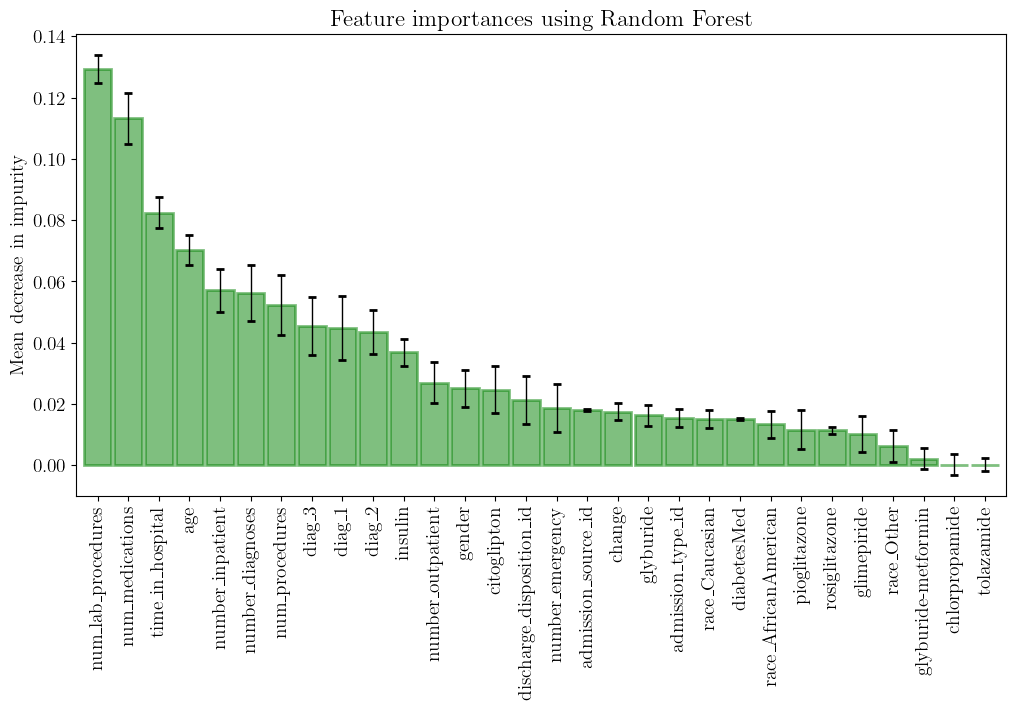

In [5]:


forest = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')
forest.fit(dFeat, dClass)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame(importances, index=dFeat_df.columns, columns=["Importance"])
forest_importances = forest_importances.sort_values(by="Importance", ascending=False)

forest_importances.plot.bar(yerr=std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=2)
plt.title("Feature importances using Random Forest") 
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in impurity")
plt.savefig("Plots/feature_importances_MDI.png", bbox_inches='tight', dpi=300)
plt.show()

Be careful, it considers that the labels are true (?)

## Feature Permutation

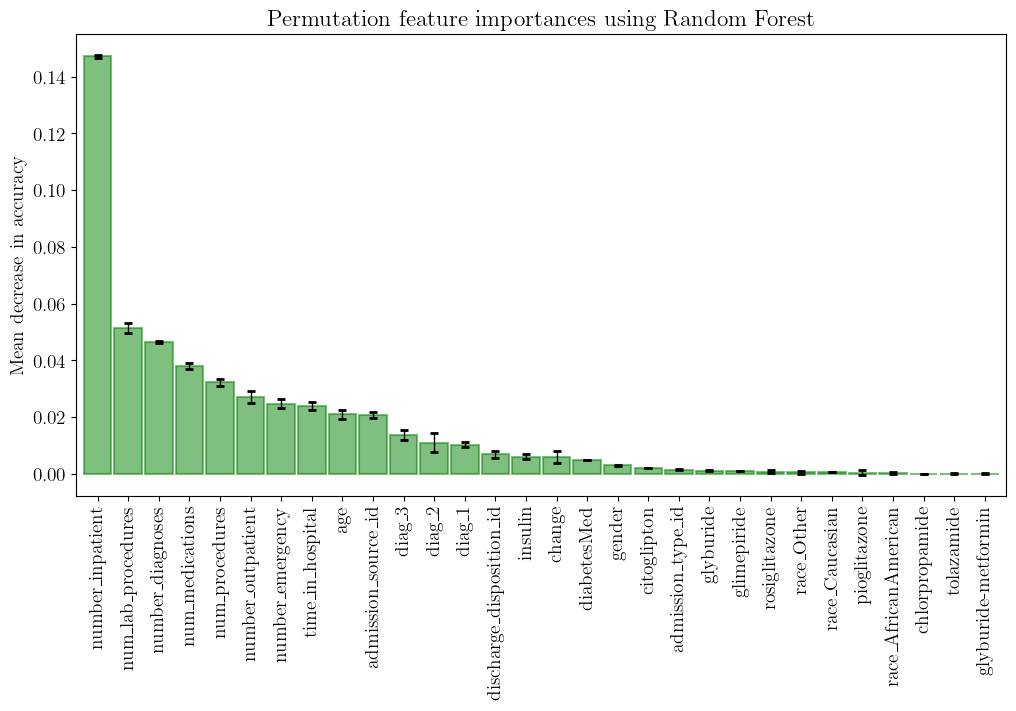

In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, dFeat, dClass, n_repeats=10, random_state=random_seed, n_jobs=-1)
forest_permutations = pd.DataFrame(result.importances_mean, index=dFeat_df.columns, columns=["Permutation Importance"])
forest_permutations = forest_permutations.sort_values(by="Permutation Importance", ascending=False)

forest_permutations.plot.bar(yerr=result.importances_std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
plt.title("Permutation feature importances using Random Forest")
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in accuracy")
plt.savefig("Plots/feature_importances_permutation.png", bbox_inches='tight', dpi=300)
plt.show()

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models_dict = {
    "RF": RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy'), # Random Forest
    "DT": DecisionTreeClassifier(random_state=random_seed, criterion='gini', max_depth=8), # Decision Tree
    "KNN": KNeighborsClassifier(n_neighbors=90, n_jobs=-1), # K-Nearest Neighbors
    "GNB": GaussianNB(), # Gaussian Naive Bayes
    "SVC": SVC(random_state=random_seed, kernel='poly', C=1, probability=True), # Support Vector Classifier
    "LR": LogisticRegression(random_state=random_seed, C=1), # Logistic Regression
}

Training RF model...


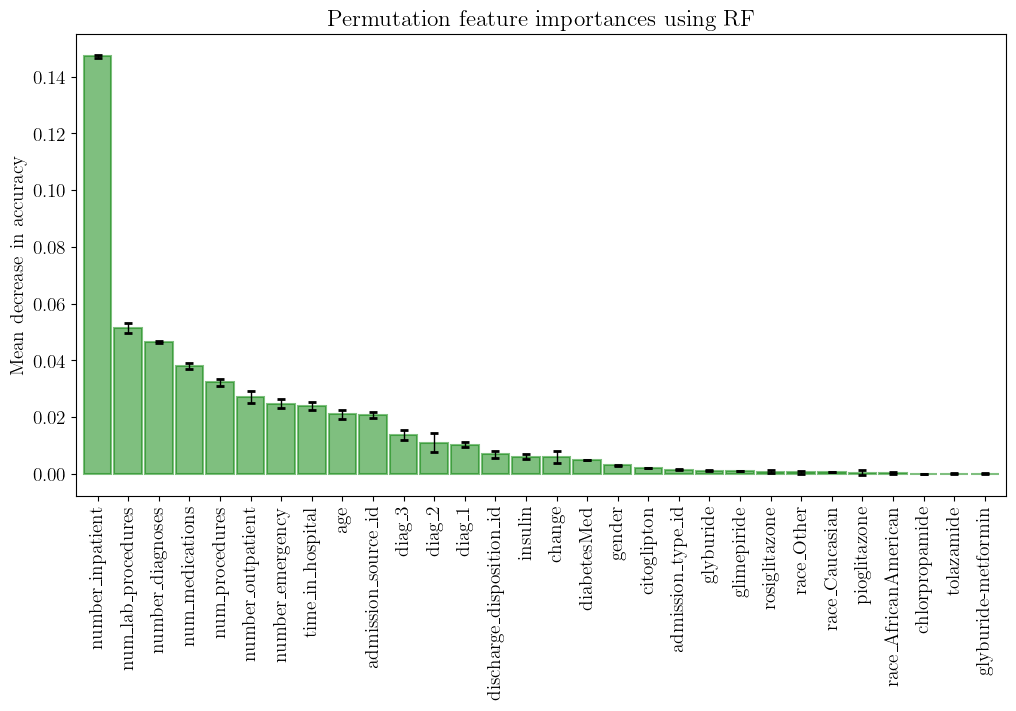

Training DT model...


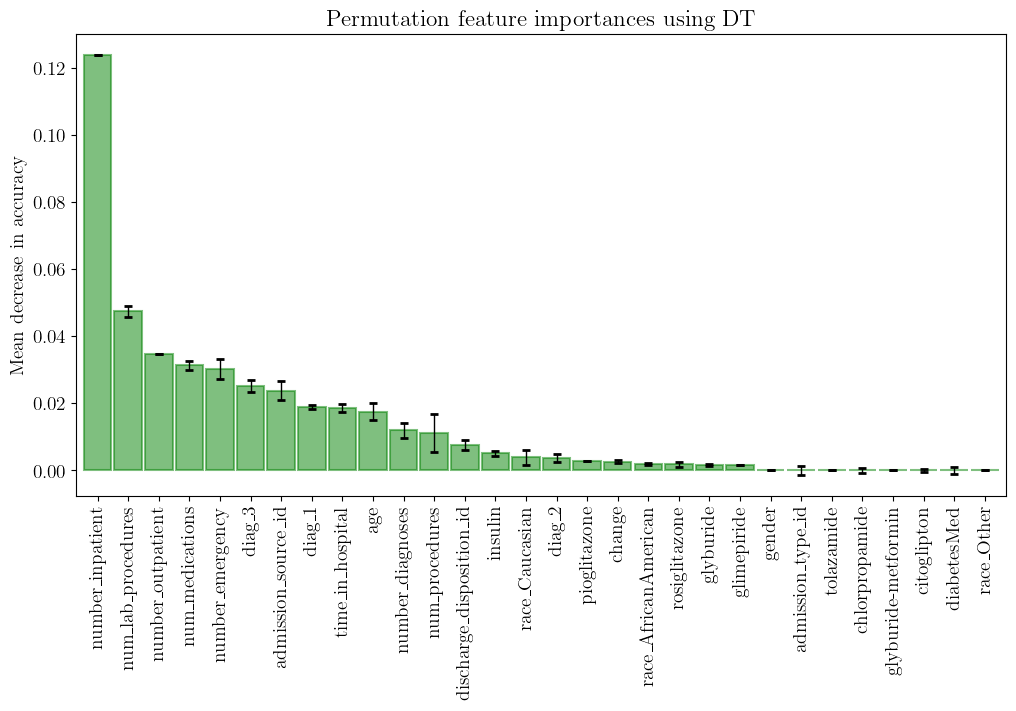

Training KNN model...


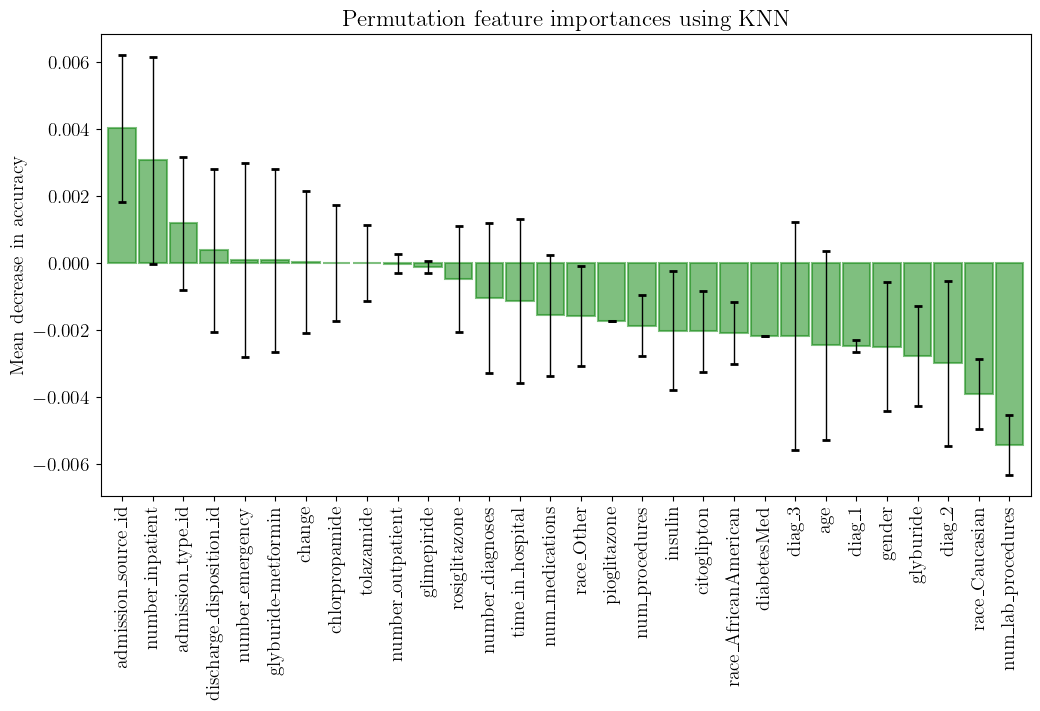

Training GNB model...


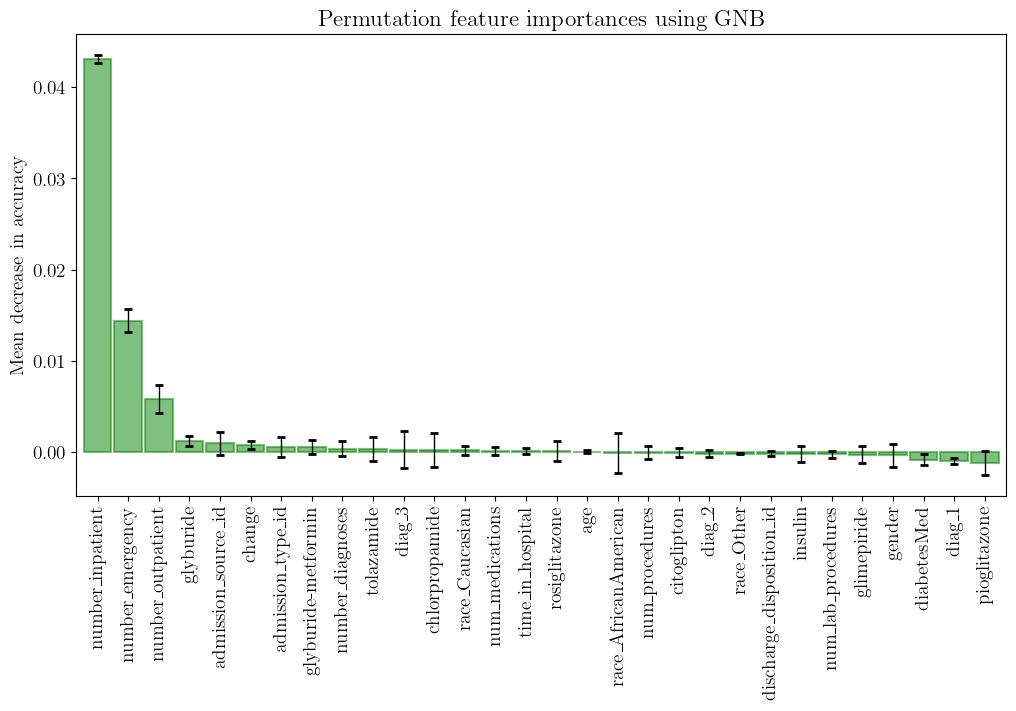

Training SVC model...


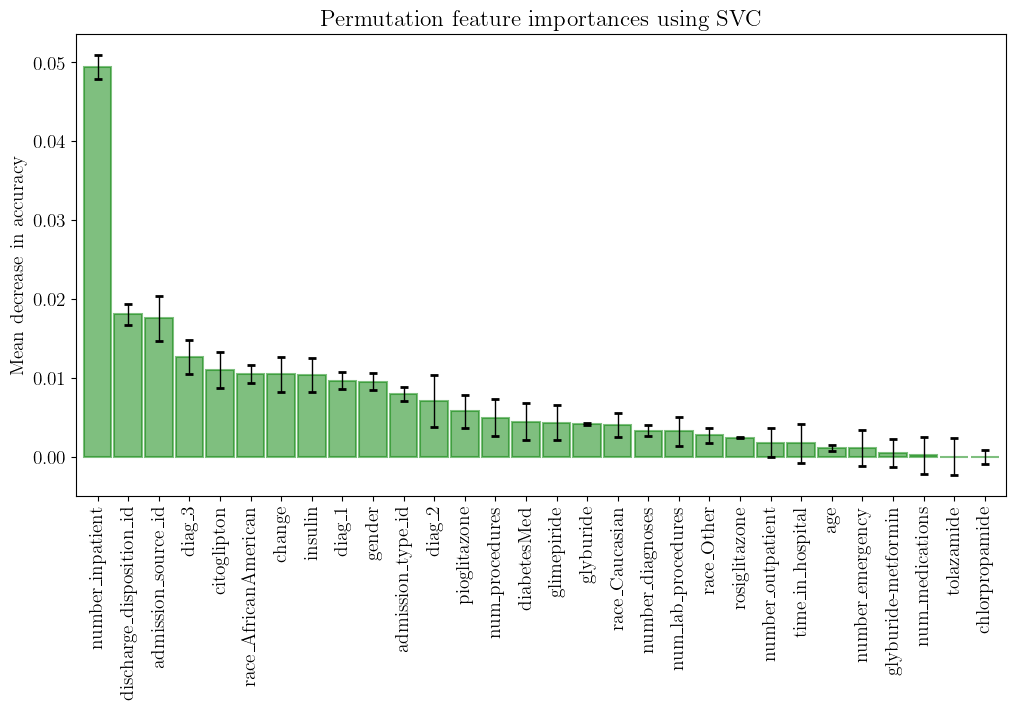

Training LR model...


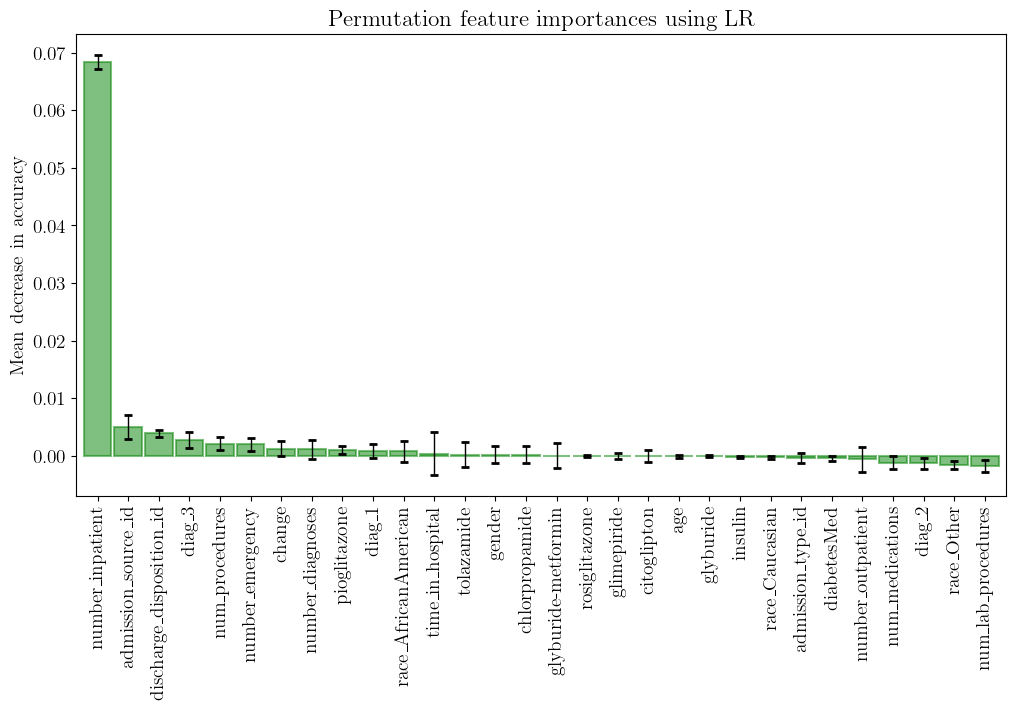

In [8]:
for model_name, model in models_dict.items():

    print(f"Training {model_name} model...")
    model1 = model

    # Fit the model before calculating permutation importance
    model1.fit(dFeat, dClass)
    result = permutation_importance(model1, dFeat, dClass, n_repeats=10, random_state=random_seed, n_jobs=-1)
    model_permutations = pd.DataFrame(result.importances_mean, index=dFeat_df.columns, columns=["Permutation Importance"])
    model_permutations = model_permutations.sort_values(by="Permutation Importance", ascending=False)
    model_permutations.plot.bar(yerr=result.importances_std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
    plt.title(f"Permutation feature importances using {model_name}")
    plt.xticks(rotation=90)
    plt.ylabel("Mean decrease in accuracy")
    plt.show() 

In [9]:
forest_permutations

,Permutation Importance
number_inpatient,0.147137
num_lab_procedures,0.051499
number_diagnoses,0.046392
num_medications,0.038040
num_procedures,0.032231
number_outpatient,0.027145
number_emergency,0.024685
time_in_hospital,0.023940
age,0.020943
admission_source_id,0.020695


We can analyze the impact of deleting features starting from the least important in terms of MDA.

In [10]:
forest_permutations_asc = forest_permutations.sort_values(by="Permutation Importance", ascending=True)
accuracy_list = []

acc_full_features = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)
dFeat_df1 = dFeat_df.copy()

for i in range(dFeat.shape[1]):

    column = forest_permutations_asc.index[:i]

    dFeat1 = dFeat_df1.drop(columns=column)
    dFeat1 = dFeat1.to_numpy()
    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat1, dClass):

        X_train, X_test = dFeat1[train_index], dFeat1[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy without ", column, ": ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy without  Index([], dtype='object') :  0.6293208767517068
Accuracy without  Index(['glyburide-metformin'], dtype='object') :  0.6286963366014748
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide'], dtype='object') :  0.6313874202214124
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide'], dtype='object') :  0.6270408774361345
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide',
       'race_AfricanAmerican'],
      dtype='object') :  0.629314460243314
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide',
       'race_AfricanAmerican', 'pioglitazone'],
      dtype='object') :  0.6280799240285406
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide',
       'race_AfricanAmerican', 'pioglitazone', 'race_Caucasian'],
      dtype='object') :  0.6336601474941396
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide',
       'race_AfricanAmeric

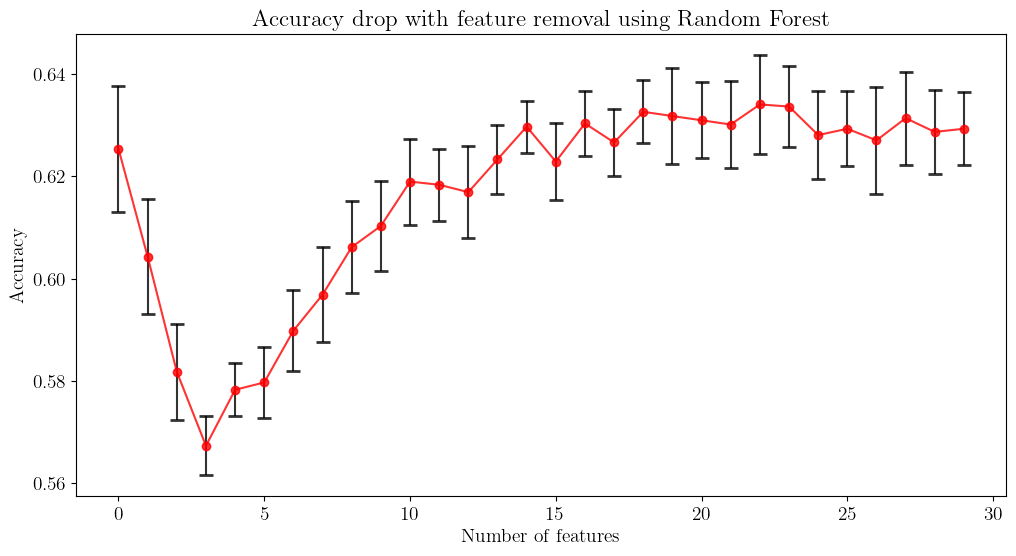

In [11]:
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(forest_permutations_asc))[::-1],accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy drop with feature removal using Random Forest")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.savefig("Plots/accuracy_drop.png", bbox_inches='tight', dpi=300)
plt.show()

In [12]:
features_str = forest_permutations_asc.index.to_list()
features_str[:11]

['glyburide-metformin',
 'chlorpropamide',
 'tolazamide',
 'race_AfricanAmerican',
 'pioglitazone',
 'race_Caucasian',
 'race_Other',
 'rosiglitazone',
 'glimepiride',
 'glyburide',
 'admission_type_id']

In [13]:
# Delete the follwoing features according to the analysis above
# dFeat_df = dFeat_df.drop(columns=["race_Other", "race_Caucasian", "race_AfricanAmerican", "glyburide-metformin", "glimepiride", "pioglitazone", "rosiglitazone", "tolazamide", "chlorpropamide", "citoglipton", "glyburide"])
dFeat_df = dFeat_df.drop(columns=features_str[:11])
dFeat = dFeat_df.to_numpy()
dFeat.shape

(4837, 19)

# Cross-Validation

In this section we study how the accuracy variation is reflected in the number of $k$ groups for cross-validation. For simplicity we just consider random forest.

In [14]:
n_splits_list = [2, 5, 7, 9, 10, 15, 20, 25, 30, 50, 100]
accuracy_list = []
error_list = []

for n_splits in n_splits_list:

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())

    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_splits, " folds: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  2  folds:  0.6195983957989053
Accuracy with  5  folds:  0.6264212824873725
Accuracy with  7  folds:  0.6336572255530287
Accuracy with  9  folds:  0.6332436463378708
Accuracy with  10  folds:  0.6326292284790309
Accuracy with  15  folds:  0.6293079245428149
Accuracy with  20  folds:  0.620843763931278
Accuracy with  25  folds:  0.6297206345814861
Accuracy with  30  folds:  0.6268103161822969
Accuracy with  50  folds:  0.632233676975945
Accuracy with  100  folds:  0.6342389455782311


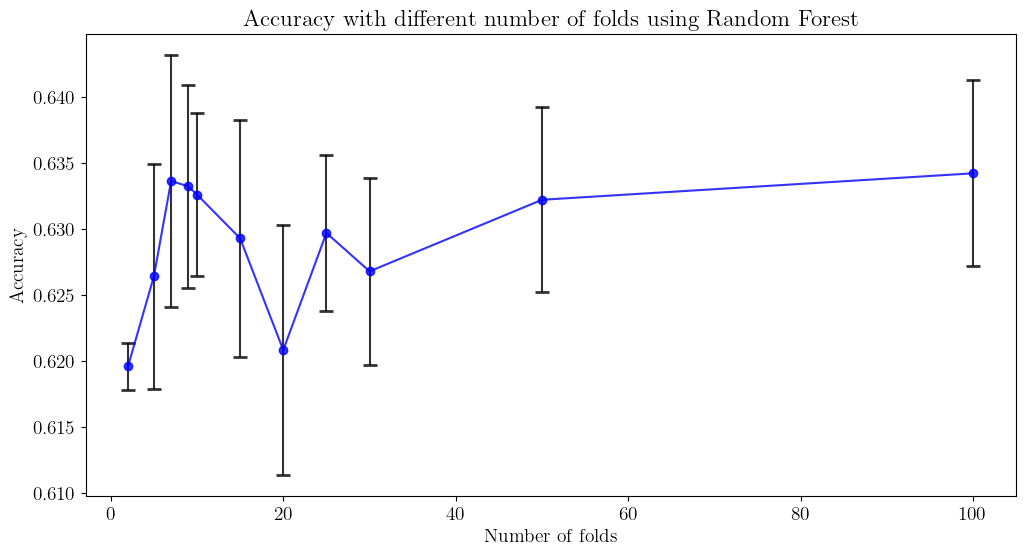

In [15]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_splits_list, accuracy_list, yerr=error_list, fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black')
plt.title("Accuracy with different number of folds using Random Forest")
plt.xlabel("Number of folds")
plt.ylabel("Accuracy")
plt.savefig("Plots/accuracy_folds_RF.png", bbox_inches='tight', dpi=300)
plt.show()

# Model Parameters

## Random Forest

Parameter to be considered: n_estimators (number of trees in the forest)

In [16]:
n_estimators_list = [5, 10, 25, 50, 100, 200, 300, 400, 500]
criterion_list = ['gini', 'entropy', 'log_loss']

accuracy_array = np.zeros((len(criterion_list), len(n_estimators_list)))
error_array = np.zeros((len(criterion_list), len(n_estimators_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, criterion in enumerate(criterion_list):

    for j, n_estimators in enumerate(n_estimators_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_seed, criterion=criterion)

            # Fit the model on the training data
            rf.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = rf.predict(X_test)

            # Calculate performance metrics
            pm = Performance_metrics(y_test, y_pred)
            accuracy_mean.append(pm.accuracy())
        
        acc = np.mean(accuracy_mean)
        print("Accuracy with ", n_estimators, " estimators: ", acc)
        accuracy_array[i, j] = acc
        error_array[i, j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Accuracy with  5  estimators:  0.5681138031928545
Accuracy with  10  estimators:  0.5995444279041117
Accuracy with  25  estimators:  0.6086451756412232
Accuracy with  50  estimators:  0.6202218400835002
Accuracy with  100  estimators:  0.6324170559348425
Accuracy with  200  estimators:  0.6334509693205346
Accuracy with  300  estimators:  0.6338684701332922
Accuracy with  400  estimators:  0.6355226459969543
Accuracy with  500  estimators:  0.6361407696387933
Accuracy with  5  estimators:  0.580109251749568
Accuracy with  10  estimators:  0.602232944920692
Accuracy with  25  estimators:  0.6150488510172305
Accuracy with  50  estimators:  0.6206316410861865
Accuracy with  100  estimators:  0.6326292284790309
Accuracy with  200  estimators:  0.6332460688191913
Accuracy with  300  estimators:  0.6324264668138186
Accuracy with  400  estimators:  0.633870181202197
Accuracy with  500  estimators:  0.635112844994268
Accuracy with  5  estimators:  0.580109251749568
Accuracy with  10  estimators

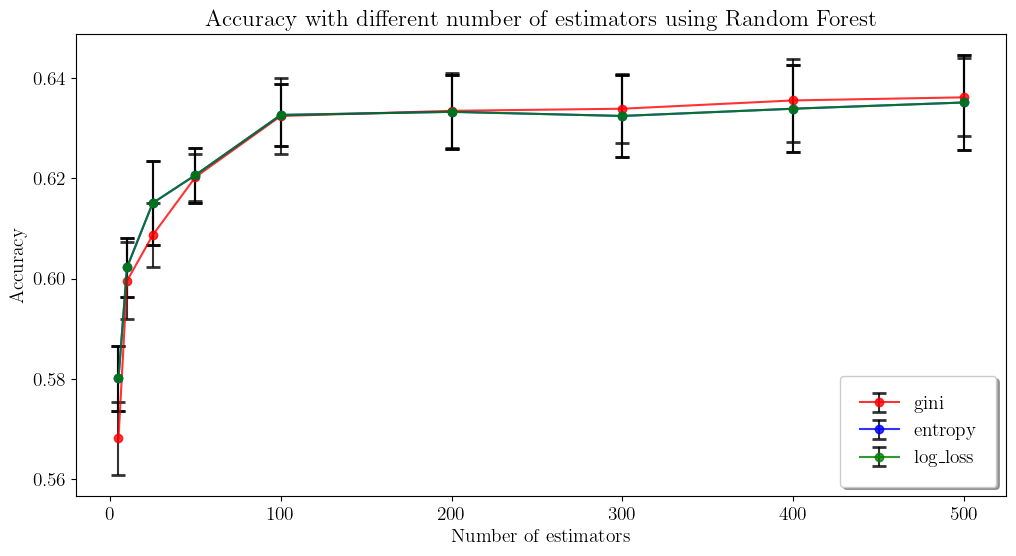

In [17]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_estimators_list, accuracy_array[0], yerr=error_array[0], fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[0])
plt.errorbar(n_estimators_list, accuracy_array[1], yerr=error_array[1], fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[1])
plt.errorbar(n_estimators_list, accuracy_array[2], yerr=error_array[2], fmt='o-', color='green', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[2])
plt.title("Accuracy with different number of estimators using Random Forest")
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=14, shadow=True, borderpad=1)
plt.savefig("Plots/accuracy_estimators_RF.png", bbox_inches='tight', dpi=300)
plt.show()

In [18]:
# get the best n_estimators and criterion
best_accuracy = 0
best_n_estimators = 0
best_criterion_rf = ""

for i, criterion in enumerate(criterion_list):

    for j, n_estimators in enumerate(n_estimators_list):

        if accuracy_array[i, j] > best_accuracy:

            best_accuracy = accuracy_array[i, j]
            best_n_estimators = n_estimators
            best_criterion_rf = criterion

Then, we select n_estimators = 100.

## Decision Tree

For the DecisionTreeClassifier we study the variation of max_depth parameter (maximum depth of the tree).

In [19]:
from sklearn.tree import DecisionTreeClassifier

criterion_list = ['gini', 'entropy', 'log_loss']
max_depth_list = [1,2,3,4,5,6,7,8,9,10,13,18,22,25,35, 50]

accuracy_array = np.zeros((len(criterion_list), len(max_depth_list)))
error_array = np.zeros((len(criterion_list), len(max_depth_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, criterion in enumerate(criterion_list):

    print("Criterion: ", criterion)

    for j, max_depth in enumerate(max_depth_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create Classifier
            dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_seed, criterion=criterion)

            # Fit the model on the training data
            dt.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = dt.predict(X_test)

            # Calculate performance metrics
            pm = Performance_metrics(y_test, y_pred)
            accuracy_mean.append(pm.accuracy())
        
        acc = np.mean(accuracy_mean)
        print("Accuracy with ", max_depth, " as max_depth: ", acc)
        accuracy_array[i][j] = acc
        error_array[i][j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Criterion:  gini
Accuracy with  1  as max_depth:  0.6256010129527916
Accuracy with  2  as max_depth:  0.624979467173143
Accuracy with  3  as max_depth:  0.6251865065106171
Accuracy with  4  as max_depth:  0.6218790103177454
Accuracy with  5  as max_depth:  0.630353079068494
Accuracy with  6  as max_depth:  0.621459798436083
Accuracy with  7  as max_depth:  0.6220809164485054
Accuracy with  8  as max_depth:  0.6222853891826224
Accuracy with  9  as max_depth:  0.6119552384374518
Accuracy with  10  as max_depth:  0.6045078110295502
Accuracy with  13  as max_depth:  0.5871447393186524
Accuracy with  18  as max_depth:  0.5652255188816453
Accuracy with  22  as max_depth:  0.5563416491282104
Accuracy with  25  as max_depth:  0.5484874150882056
Accuracy with  35  as max_depth:  0.5484852762520747
Accuracy with  50  as max_depth:  0.5484852762520747
Criterion:  entropy
Accuracy with  1  as max_depth:  0.6256010129527916
Accuracy with  2  as max_depth:  0.624979467173143
Accuracy with  3  as max

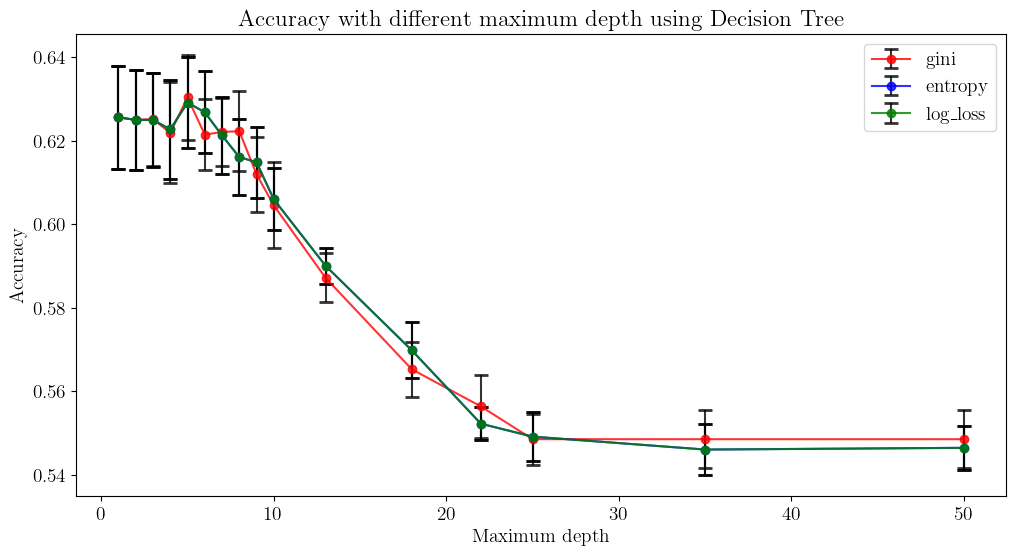

In [20]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(max_depth_list, accuracy_array[0], yerr=error_array[0], fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[0])
plt.errorbar(max_depth_list, accuracy_array[1], yerr=error_array[1], fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[1])
plt.errorbar(max_depth_list, accuracy_array[2], yerr=error_array[2], fmt='o-', color='green', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[2])
plt.title("Accuracy with different maximum depth using Decision Tree")
plt.xlabel("Maximum depth")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=14)
plt.savefig("Plots/accuracy_max_depth_DT.png", bbox_inches='tight', dpi=300)
plt.show()

In [21]:
# get criterion and max_depth with best accuracy
best_accuracy = 0
best_criterion_dt = ""
best_max_depth = 0

for i, criterion in enumerate(criterion_list):
    for j, max_depth in enumerate(max_depth_list):
        if accuracy_array[i][j] > best_accuracy:
            best_accuracy = accuracy_array[i][j]
            best_criterion_dt = criterion
            best_max_depth = max_depth

## K-nearest Neighbors

In this classifier we consider how the accuracy varies depending on the number of neighbors (n_neighbors)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_list = [5, 10, 25, 50, 75, 90, 100, 110, 125, 150, 200, 250 ,300, 400, 500]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for n_neighbors in n_neighbors_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create Classifier
        kn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)

        # Fit the model on the training data
        kn.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = kn.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_neighbors, " neighbors: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  5  neighbors:  0.5393759731704396
Accuracy with  10  neighbors:  0.5472370514860634
Accuracy with  25  neighbors:  0.5606740755950244
Accuracy with  50  neighbors:  0.5644080557124036
Accuracy with  75  neighbors:  0.5662619988706945
Accuracy with  90  neighbors:  0.5642001608404771
Accuracy with  100  neighbors:  0.5642027274438342
Accuracy with  110  neighbors:  0.5656464418322125
Accuracy with  125  neighbors:  0.5652327909244905
Accuracy with  150  neighbors:  0.5592299334394196
Accuracy with  200  neighbors:  0.5658432147562582
Accuracy with  250  neighbors:  0.5646065397053539
Accuracy with  300  neighbors:  0.5606770699656074
Accuracy with  400  neighbors:  0.5660570983693514
Accuracy with  500  neighbors:  0.5623355235015314


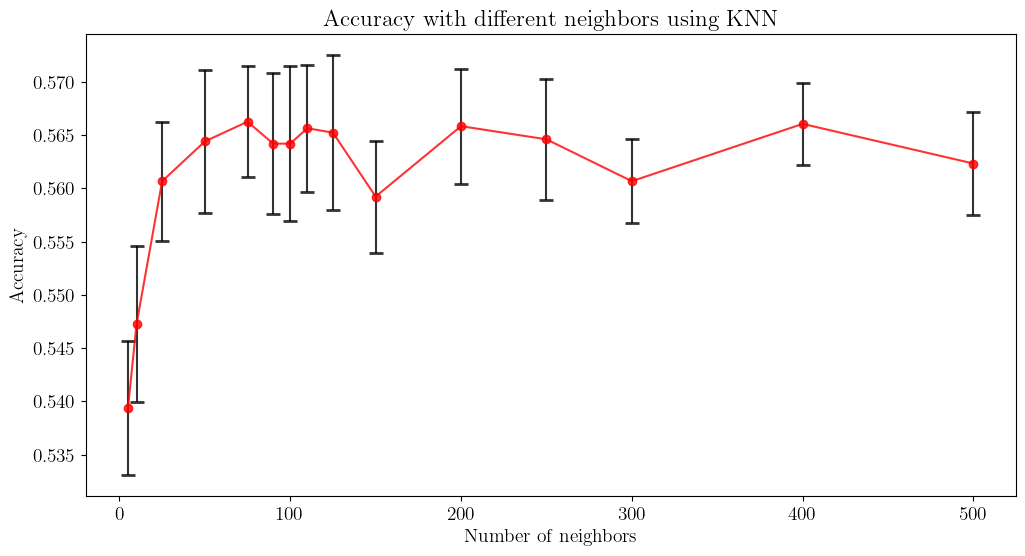

In [23]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_neighbors_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different neighbors using KNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.savefig("Plots/accuracy_neighbors_KNN.png", bbox_inches='tight', dpi=300)
plt.show()

In [24]:
# get the best n_neighbors with best accuracy
best_accuracy = 0
best_n_neighbors = 0
for i, n_neighbors in enumerate(n_neighbors_list):
    if accuracy_list[i] > best_accuracy:
        best_accuracy = accuracy_list[i]
        best_n_neighbors = n_neighbors

## Gaussian Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

No analysis performed in this model.

## Support Vector Machine

Now, we study the effect of the regularization parameter for different kernels.

In [26]:
from sklearn.svm import SVC

kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
C_list = [0.01, 0.05, 0.1, 0.5, 1, 2, 5]

accuracy_array = np.zeros((len(kernel_list), len(C_list)))
error_array = np.zeros((len(kernel_list), len(C_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, kernel in enumerate(kernel_list):

    print("Kernel: ", kernel)

    for j, C in enumerate(C_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create Classifier
            svc = SVC(kernel=kernel, C=C, random_state=random_seed)

            # Fit the model on the training data
            svc.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = svc.predict(X_test)


            # Calculate performance metrics
            try:
                pm = Performance_metrics(y_test, y_pred)
                accuracy_mean.append(pm.accuracy())

            except Exception as e:
                break
        
        if accuracy_mean == []:
            print("No accuracy calculated for ", kernel, " with C = ", C)
            acc = 0
        else:
            acc = np.mean(accuracy_mean)
            print("Accuracy with C ", C ," : ", acc)
        
        accuracy_array[i][j] = acc
        error_array[i][j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Kernel:  linear
No accuracy calculated for  linear  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.05  :  0.5633643036805092
Accuracy with C  0.1  :  0.5778365244768408
Accuracy with C  0.5  :  0.6115394486935989
Accuracy with C  1  :  0.6109187584484026
Accuracy with C  2  :  0.6123654672073643
Accuracy with C  5  :  0.6150531286894922
Kernel:  poly
Accuracy with C  0.01  :  0.5661157024793388
Accuracy with C  0.05  :  0.5929277244494635
Accuracy with C  0.1  :  0.6020306110227058
Accuracy with C  0.5  :  0.6082272470612391
Accuracy with C  1  :  0.6121515835942712
Accuracy with C  2  :  0.6096726725185223
Accuracy with C  5  :  0.5987145594853105
Kernel:  rbf
No accuracy calculated for  rbf  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No accuracy calculated for  rbf  with C =  0.05


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.1  :  0.5637779545882313
Accuracy with C  0.5  :  0.5983017641120408
Accuracy with C  1  :  0.6102933627637186
Accuracy with C  2  :  0.6175299009291104
Accuracy with C  5  :  0.6133925363174375
Kernel:  sigmoid
No accuracy calculated for  sigmoid  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.05  :  0.5517863559365537
Accuracy with C  0.1  :  0.5034217100422633
Accuracy with C  0.5  :  0.5001125027804869
Accuracy with C  1  :  0.4988702667556423
Accuracy with C  2  :  0.49866408295262044
Accuracy with C  5  :  0.4968024399842582


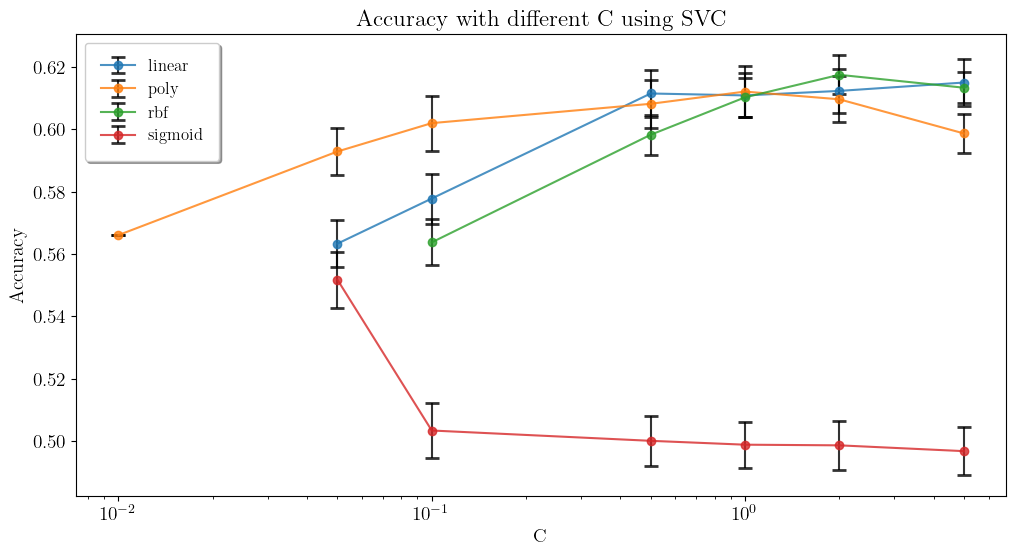

In [27]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
for i in range(len(kernel_list)):
    acc = accuracy_array[i][accuracy_array[i] != 0]
    filtered_C_list = np.array(C_list)[accuracy_array[i] != 0]  # Use a different variable name
    error = error_array[i][accuracy_array[i] != 0]
    plt.errorbar(filtered_C_list, acc, yerr=error, fmt='o-', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=kernel_list[i])
plt.xscale('log')
plt.title("Accuracy with different C using SVC")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=12, shadow=True, borderpad=1)
plt.savefig("Plots/accuracy_C_SVC.png", bbox_inches='tight', dpi=300)
plt.show()

In [28]:
# get the best kernel and C with best accuracy
best_accuracy = 0
best_kernel = ""
best_C_svc = 0

for i, kernel in enumerate(kernel_list):
    for j, C in enumerate(C_list):
        if accuracy_array[i][j] > best_accuracy:
            best_accuracy = accuracy_array[i][j]
            best_kernel = kernel
            best_C_svc = C


## Logistic Regression

Finally we analyze the maximum iterations effect.

In [29]:
from sklearn.linear_model import LogisticRegression

C_list = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for C in C_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create Classifier
        lr = LogisticRegression(random_state=random_seed, C=C)

        # Fit the model on the training data
        lr.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = lr.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with C ", C , " : ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with C  0.01  :  0.5683268312714953
Accuracy with C  0.05  :  0.5908658864192462
Accuracy with C  0.1  :  0.6069948496825968
Accuracy with C  0.5  :  0.6258063412213609
Accuracy with C  1  :  0.627049005013432
Accuracy with C  2  :  0.6270477217117533
Accuracy with C  5  :  0.627667556422497
Accuracy with C  10  :  0.6272521944458702
Accuracy with C  20  :  0.6270455828756223
Accuracy with C  50  :  0.6266315042006741
Accuracy with C  100  :  0.626631076433448


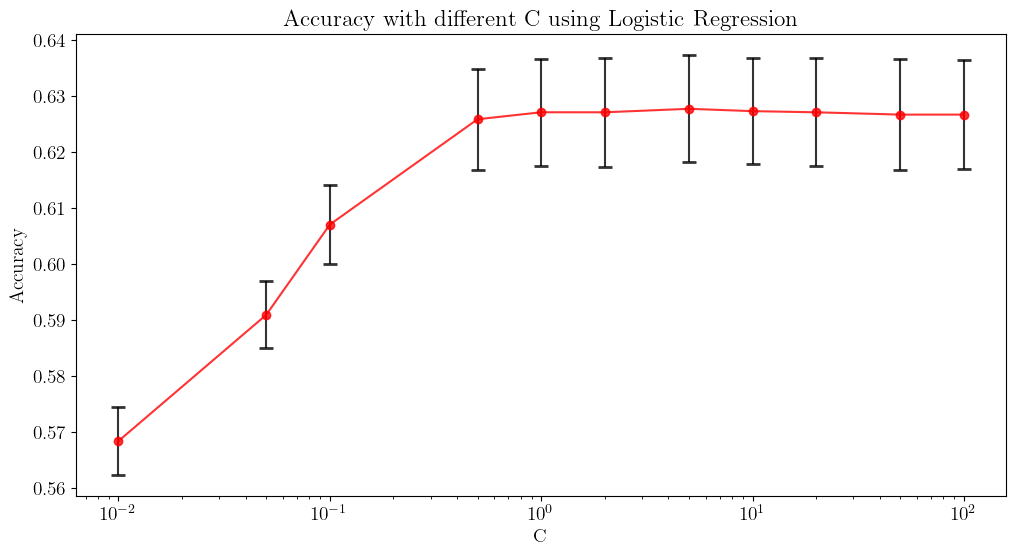

In [30]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(C_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different C using Logistic Regression")
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("Plots/accuracy_C_LR.png", bbox_inches='tight', dpi=300)
plt.show()

In [31]:
# Get the best C with best accuracy
best_accuracy = 0
best_C_lr = 0
for i, C in enumerate(C_list):
    if accuracy_list[i] > best_accuracy:
        best_accuracy = accuracy_list[i]
        best_C_lr = C

In [46]:
models_dict = {
    "RF": RandomForestClassifier(n_estimators=best_n_estimators, random_state=random_seed, criterion=best_criterion_rf), # Random Forest
    "DT": DecisionTreeClassifier(random_state=random_seed, criterion=best_criterion_dt, max_depth=best_max_depth), # Decision Tree
    "KNN": KNeighborsClassifier(n_neighbors=best_n_neighbors, n_jobs=-1), # K-Nearest Neighbors
    "GNB": GaussianNB(), # Gaussian Naive Bayes
    "SVC": SVC(random_state=random_seed, kernel='linear', C=best_C_svc, probability=True), # Support Vector Classifier
    "LR": LogisticRegression(random_state=random_seed, C=best_C_lr), # Logistic Regression
}

In [ ]:
print("Best parameters for each model:")
print("Random Forest: ", best_n_estimators, best_criterion_rf)
print("Decision Tree: ", best_criterion_dt, best_max_depth)
print("KNN: ", best_n_neighbors)
print("Gaussian Naive Bayes: ", "N/A")
print("SVC: ", best_kernel, best_C_svc) # Although the kernel is rbf, we set linear for the final model
print("Logistic Regression: ", best_C_lr)

Best parameters for each model:
Random Forest:  500 gini
Decision Tree:  gini 5
KNN:  75
Gaussian Naive Bayes:  N/A
SVC:  rbf 2
Logistic Regression:  5


# ROC Curve

In [48]:
# Now we compute the ROC curve and AUC for the different classifiers
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


Roc_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dFeat, dClass, test_size=0.2, random_state=random_seed)

# Compute each classification task
for clf_name, clf in models_dict.items():

    print(f"Classifier: {clf_name}")
    # Create a Random Forest Classifier
    model = clf

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    mean_auc = auc(fpr, tpr)

    Roc_dict[clf_name].append((fpr, tpr, auc))

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


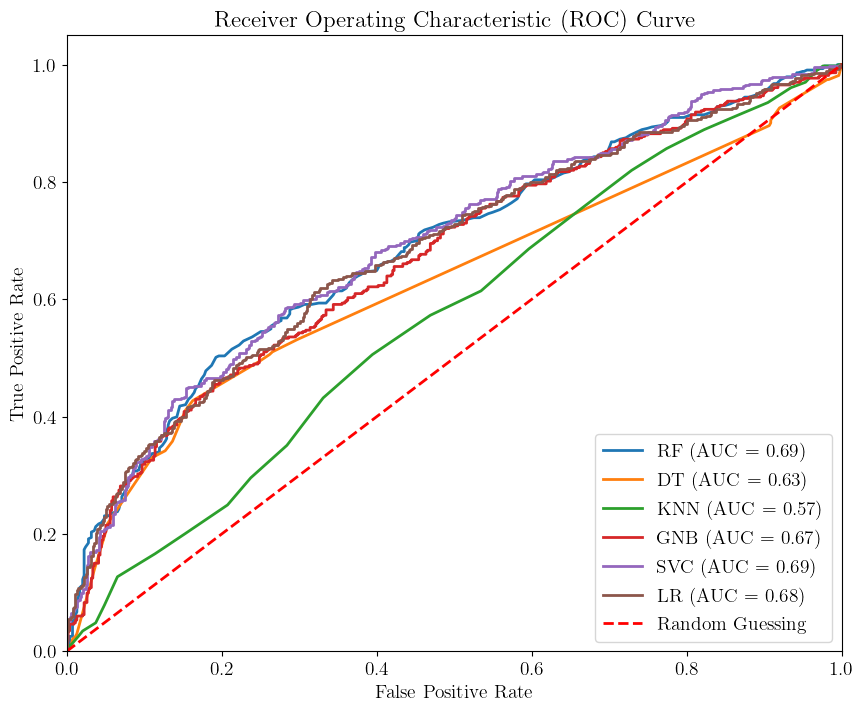

In [49]:
# Plotting the ROC curves for each classifier
plt.figure(figsize=(10, 8))

for clf_name, meas_list in Roc_dict.items():
    mean_fpr = meas_list[0][0]
    mean_tpr = meas_list[0][1]
    mean_auc = auc(mean_fpr, mean_tpr)  # Calculate the AUC value
    plt.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("Plots/ROC_curve.png", bbox_inches='tight', dpi=300)
plt.show()

# Model measure comparison

In this section we compare the measures and the performance metrics and cost for each classifier.

In [50]:
import time

kf = KFold(n_splits=7, shuffle=True, random_state=random_seed)

Performance_metrics_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

for model_name, model in models_dict.items():

    print(f"Classifier: {model_name}")

    accuracy_list = []
    precision_list = []
    recall_list = []
    f_measure_list = []
    cost_list = []

    start = time.time()

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_list.append(pm.accuracy())
        precision_list.append(pm.precision())
        recall_list.append(pm.recall())
        f_measure_list.append(pm.f_measure())
        cost_list.append(pm.cost())

    end = time.time()
    print(f"Time taken for {model_name}: {end - start:.2f} seconds")

    acc = np.mean(accuracy_list)
    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f_measure = np.mean(f_measure_list)
    cost = np.mean(cost_list)

    # Store the performance metrics in the dictionary
    Performance_metrics_dict[model_name].append((acc, precision, recall, f_measure, cost))

# Create a DataFrame to store the performance metrics
performance_df = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])

for model_name, metrics in Performance_metrics_dict.items():
    acc, precision, recall, f_measure, cost = metrics[0]
    performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)

performance_df = performance_df.set_index("Classifier")
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)
performance_df

Classifier: RF
Time taken for RF: 25.82 seconds
Classifier: DT
Time taken for DT: 0.11 seconds
Classifier: KNN
Time taken for KNN: 0.22 seconds
Classifier: GNB
Time taken for GNB: 0.06 seconds
Classifier: SVC
Time taken for SVC: 23.73 seconds
Classifier: LR
Time taken for LR: 0.26 seconds


C:\Users\mate1\AppData\Local\Temp\ipykernel_21900\1788944820.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)


,Accuracy,Precision,Recall,F-measure,Cost
Classifier,,,,,
RF,0.637379,0.477119,0.621696,0.539576,462.000000
LR,0.626421,0.366208,0.643858,0.465905,397.000000
DT,0.624561,0.435981,0.611843,0.507137,467.285714
GNB,0.612983,0.263191,0.666877,0.376893,349.142857
SVC,0.611950,0.225299,0.699375,0.340417,317.571429
KNN,0.569568,0.298403,0.531573,0.381192,531.285714


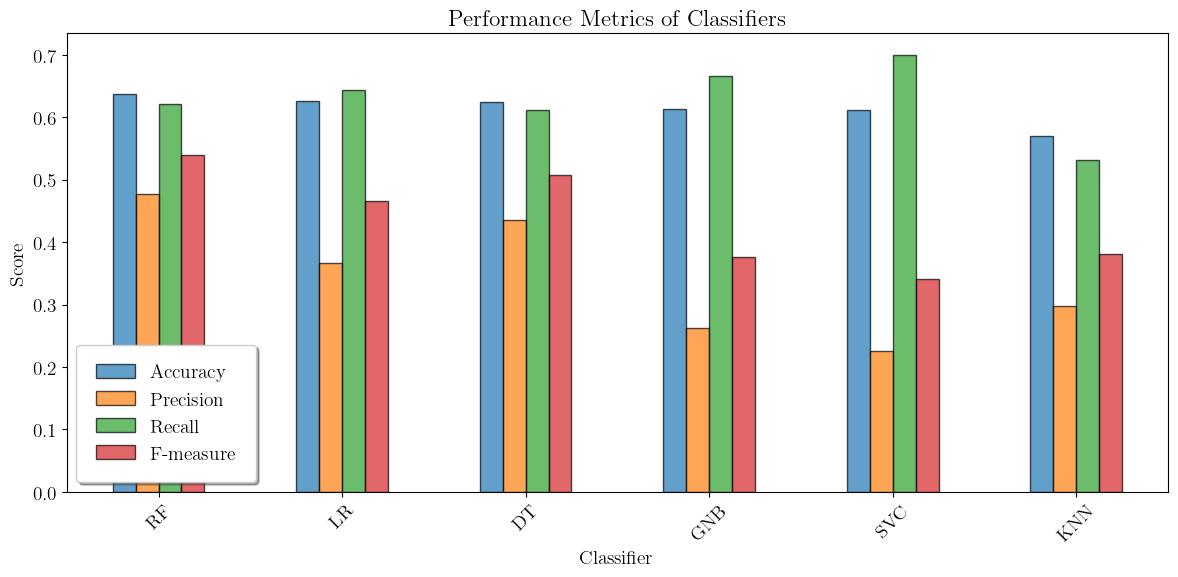

In [54]:
# Plot bar chart of performance metrics
no_cost_df = performance_df.drop(columns=["Cost"])

no_cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='lower left', fontsize=14, shadow=True, borderpad=1)
plt.savefig("Plots/performance_metrics.png", bbox_inches='tight', dpi=300)
plt.show()

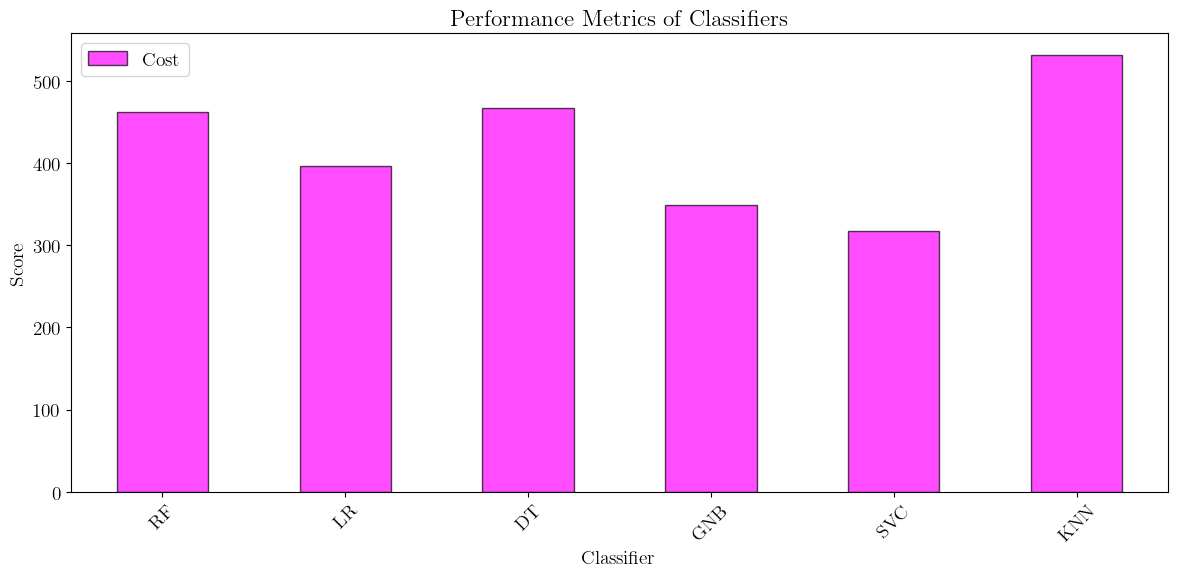

In [52]:
cost_df = performance_df.drop(columns=["Accuracy", "Precision", "Recall", "F-measure"])

cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black', color='magenta')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/performance_cost.png", bbox_inches='tight', dpi=300)
plt.show()